In [1]:
using Revise

In [2]:
using QuantumOptics
using PyPlot
using LinearAlgebra

┌ Info: Recompiling stale cache file /home/alexander/.julia/compiled/v1.1/QuantumOptics/gWeRI.ji for QuantumOptics [6e0679c1-51ea-5a7c-ac74-d61b76210b0c]
└ @ Base loading.jl:1184


In [3]:
pauli_basis = (Complex{Float64}[1 0; 0 1] / √2, 
               Complex{Float64}[0 1; 1 0] / √2, 
               Complex{Float64}[0 -1im; 1im 0] / √2,
               Complex{Float64}[1 0; 0 -1] / √2)

function frobenius_norm(m0::AbstractArray, m1::AbstractArray)
    return sum(m0 .* transpose(m1))
end

function frobenius_norm(m0::DenseSuperOperator, m1::DenseSuperOperator)
    return sum(m0.data .* transpose(m1.data))
end

function pauli_ops(n::Int64)
    return map(x -> kron(x...), Iterators.product([pauli_basis for _ in 1:n]...))
end

function unitary_to_ptm(unitary:: AbstractArray)
    unitary_dim = size(unitary)[1]
    ptm_dim = unitary_dim ^ 2
    nqubits = floor(Int64, log2(unitary_dim))
    ptm = zeros(Complex{Float64}, (ptm_dim, ptm_dim))
    
    for (idx, pi) in enumerate(pauli_ops(nqubits))
#         pi = kron(pi...)
        for (jdx, pj) in enumerate(pauli_ops(nqubits))
#             pj = kron(pj...)
            ptm[idx, jdx] = frobenius_norm(unitary' * pi * unitary, pj)
        end
    end
    
    return real.(ptm)
end

function avg_gate_fidelity(meas:: AbstractArray, target:: AbstractArray)
    dim = floor(Int64, sqrt(size(meas)[1]))
    return (tr(meas' * target) + dim) / (dim^2 + dim)
end    

avg_gate_fidelity (generic function with 1 method)

In [4]:
sz = diagm(0 => Complex{Float64}[1, -1])
eye = diagm(0 => Complex{Float64}[1, 1])
cϕ(ϕ) = diagm(0 => [1, 1, 1, exp(1im * ϕ)])
cϕ(α, β, ϕ) = exp(1im * α * kron(sz, eye) / 2) * exp(1im * β * kron(eye, sz) / 2) * cϕ(ϕ)

cϕ (generic function with 2 methods)

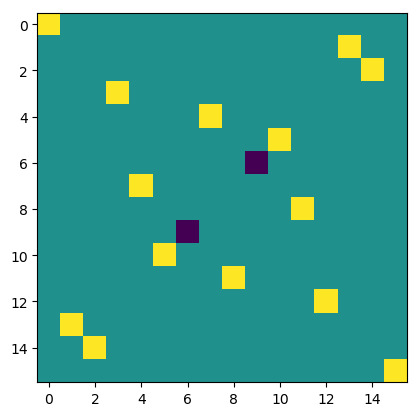

PyObject <matplotlib.image.AxesImage object at 0x7fae0c0859e8>

In [5]:
imshow(unitary_to_ptm(cϕ(0,0,π)))

In [54]:
PauliBasis(2)

PauliBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}}([2, 2], (Spin(1/2), Spin(1/2)))

In [20]:
pb = PauliBasis(2)

PauliBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}}([2, 2], (Spin(1/2), Spin(1/2)))

In [68]:
b = GenericBasis(4)
cz = DenseOperator(b, b, diagm(0=>[1,1,1,-1]))
SuperOperator(cz).basis_l == SuperOperator(cz).basis_r == (b, b)

true

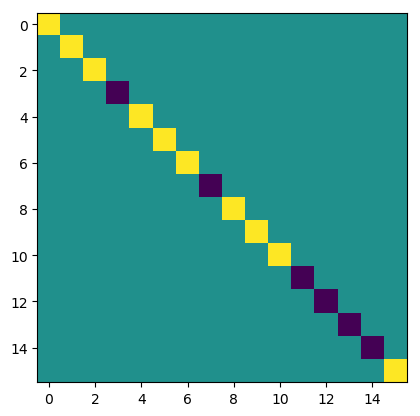

PyObject <matplotlib.image.AxesImage object at 0x7fae09d42be0>

In [51]:
cz = DenseOperator(pb, pb, cϕ(0,0,π))
czsop = SuperOperator(cz)
imshow(real.(czsop.data))

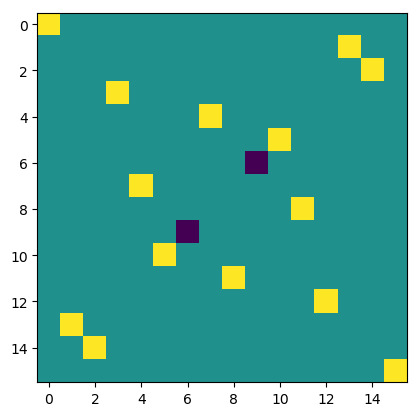

PyObject <matplotlib.image.AxesImage object at 0x7fae0e42a780>

In [78]:
temp = zeros(Float64, (16, 16))
for idx in [1,30,47,52,72,91,117,140,166,185,205,210,227,256]
    temp[idx] = 1
end
for idx in [106,151]
    temp[idx] = -1
end
imshow(temp)

In [77]:
d = convert.(Int64, round.(PauliTransferMatrix(czsop).data))
for (idx, i) in enumerate(d)
    if i == -1
        println(idx)
    end
end

106
151


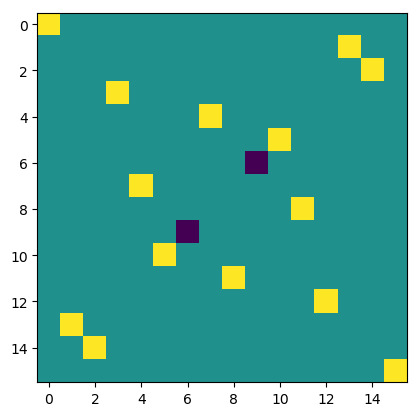

PyObject <matplotlib.image.AxesImage object at 0x7fae0e4c59b0>

In [52]:
imshow(PauliTransferMatrix(czsop).data)

In [16]:
fieldnames(typeof(myops[1].data))
d = Complex{Float64}[1 0; 0 -1]
this_basis = (myops[1].basis_l, myops[1].basis_r)
@assert typeof(d) <: Matrix{ComplexF64}
@assert typeof(this_basis) <: Tuple{Basis, Basis}

In [17]:
abstract type Vectorized{B<:Tuple{Basis,Basis}} end

In [18]:
mutable struct DenseVectorized{B<:Tuple{Basis, Basis}, T<:Array{ComplexF64, 1}} <: Vectorized{B}
    basis::B
    data::T
    function DenseVectorized(basis::Tuple{Basis, Basis}, data::Matrix{ComplexF64})
        @assert basis[1] == basis[2]
        return new{Tuple{Basis, Basis}, Array{ComplexF64, 1}}(basis, reshape(data, length(data)))
    end
end

# mutable struct SparseVectorized{B<:Tuple{Basis, Basis}, T<:SparseMatrixCSC{ComplexF64,Int}} <: Vectorized{B}
#     basis::B
#     data::T
#     function SparseVectorized{B, T}(basis::B, data::T) where {B<:Tuple{Basis, Basis}, T<:SparseMatrixCSC{ComplexF64,Int}}
#         @assert basis[1] == basis[2]
#         return new(basis, reshape(data, length(data)))
#     end
# end

In [23]:
PauliBasis(2)

PauliBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}}([2, 2], (Spin(1/2), Spin(1/2)))

In [19]:
function DenseVectorized(op::DenseOperator)
    return DenseVectorized((op.basis_l, op.basis_r), op.data)
end

function DenseVectorized(op::SparseOperator)
    return DenseVectorized((op.basis_l, op.basis_r), Matrix(op.data))
end

DenseVectorized

In [21]:
myops[3]

SparseOperator(dim=4x4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
  [2, 1]  =  0.0+1.0im
  [1, 2]  =  0.0-1.0im
  [4, 3]  =  0.0+1.0im
  [3, 4]  =  0.0-1.0im

In [20]:
DenseVectorized(myops[3])

DenseVectorized{Tuple{Basis,Basis},Array{Complex{Float64},1}}(([Spin(1/2) ⊗ Spin(1/2)], [Spin(1/2) ⊗ Spin(1/2)]), Complex{Float64}[0.0+0.0im, 0.0+1.0im, 0.0+0.0im, 0.0+0.0im, 0.0-1.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+1.0im, 0.0+0.0im, 0.0+0.0im, 0.0-1.0im, 0.0+0.0im])

In [35]:
b = czsop.basis_l[1].bases

(Spin(1/2), Spin(1/2))

In [36]:
DenseVectorized

DenseVectorized

In [67]:
typeof(myops[1].basis_r) <: Basis

true

In [62]:
reshape(myops[1].data, 16)

16-element reshape(::SparseArrays.SparseMatrixCSC{Complex{Float64},Int64}, 16) with eltype Complex{Float64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im

In [81]:
typeof(myops[1].data)

SparseArrays.SparseMatrixCSC{Complex{Float64},Int64}

In [91]:
abstract type Vectorized{B<:Tuple{Basis,Basis}} end


In [160]:
using SparseArrays
mutable struct SparseVectorized{B<:Tuple{Basis, Basis}, T<:SparseMatrixCSC{ComplexF64,Int}} <: Vectorized{B}
    basis::B
    data::T
    function SparseVectorized(basis::B) where B <: Tuple{Basis, Basis}
        return typeof(basis) <: Tuple{Basis, Basis}
    end
    function SparseVectorized3(basis::B, data::T) where {B<:Tuple{Basis, Basis}, T<:SparseMatrixCSC{ComplexF64,Int}}
        @assert basis[1] == basis[2]
        return new{typeof(basis), typeof(data)}(basis, SparseMatrixCSC(reshape(data, 16)))
    end
end

In [161]:
SparseVectorized(myops[1])

true
true


MethodError: MethodError: no method matching SparseMatrixCSC(::Base.ReshapedArray{Complex{Float64},1,SparseMatrixCSC{Complex{Float64},Int64},Tuple{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}}})
Closest candidates are:
  SparseMatrixCSC(!Matched::SparseMatrixCSC) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/SparseArrays/src/sparsematrix.jl:359
  SparseMatrixCSC(!Matched::Array{T,2} where T) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/SparseArrays/src/sparsematrix.jl:371
  SparseMatrixCSC(!Matched::Adjoint{#s623,#s622} where #s622<:SparseMatrixCSC where #s623) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/SparseArrays/src/sparsematrix.jl:402
  ...

In [153]:
function SparseVectorized(op::DataOperator)
    println(typeof((op.basis_l, op.basis_r)) <: Tuple{CompositeBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}},CompositeBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}}})
    println(typeof(op.data) <: SparseMatrixCSC{ComplexF64,Int})
    SparseVectorized3((op.basis_l, op.basis_r), op.data)
#     SparseVectorized3((op.basis_l, op.basis_r))

end

SparseVectorized

In [72]:
function DenseVectorized(op::DataOperator)
    typeof((op.basis_l, op.basis_r)) <: Tuple{Basis, Basis}
    DenseVectorized((op.basis_l, op.basis_r), op.data)
end

DenseVectorized

In [58]:
typeof(myops[1]) <: DataOperator

true

In [11]:
l

UndefVarError: UndefVarError: l not defined

In [12]:
broadcast((sigmax, sigmay), b)

MethodError: MethodError: objects of type Tuple{typeof(sigmax),typeof(sigmay)} are not callable

In [13]:
identity(b)

(Spin(1/2), Spin(1/2))

In [14]:
@assert czsop.basis_l[1] == czsop.basis_l[2]

In [15]:
typeof(czsop.basis_l[1])

PauliBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}}

In [16]:
sigmax(czsop.basis_l[1].bases[1])

SparseOperator(dim=2x2)
  basis: Spin(1/2)
  [2, 1]  =  1.0+0.0im
  [1, 2]  =  1.0+0.0im

In [17]:
PauliTransferMatrix(czsop)

UndefVarError: UndefVarError: czsop not defined

In [18]:
typeof(czsop.basis_l)

Tuple{PauliBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}},PauliBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}}}

In [19]:
typeof(czsop.basis_l) <: Tuple{PauliBasis, PauliBasis}

true

In [20]:
po = [reshape(i, 16) for i in pauli_ops(2)]
temp = zeros(Complex{Float64}, (16, 16))

for idx in 1:16
    for jdx in 1:16
        temp[idx, jdx] = po[idx]' * czsop.data * po[jdx]
    end
end

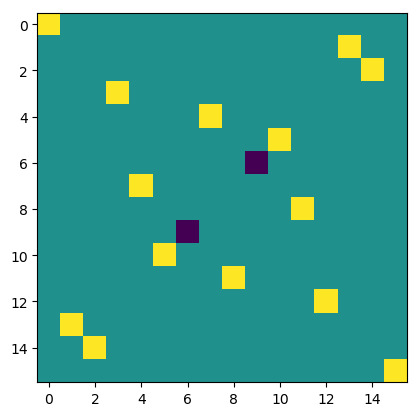

PyObject <matplotlib.image.AxesImage object at 0x7f00db2b9a20>

In [21]:
imshow(real.(temp))

In [22]:
PauliBasis(2)

PauliBasis{Tuple{SpinBasis{1//2},SpinBasis{1//2}}}([2, 2], (Spin(1/2), Spin(1/2)))

In [23]:
sigmax(bb)

UndefVarError: UndefVarError: bb not defined

In [24]:
b⊗b

MethodError: MethodError: no method matching tensor(::Tuple{SpinBasis{1//2},SpinBasis{1//2}}, ::Tuple{SpinBasis{1//2},SpinBasis{1//2}})

In [25]:
bb = b⊗b
SuperOperator(DenseOperator(bb, cϕ(π)))

MethodError: MethodError: no method matching tensor(::Tuple{SpinBasis{1//2},SpinBasis{1//2}}, ::Tuple{SpinBasis{1//2},SpinBasis{1//2}})

In [26]:
typeof(PauliBasis(1)) <: SpinBasis

ErrorException: type SpinBasis has no field bases

In [27]:
bb.bases

UndefVarError: UndefVarError: bb not defined

In [28]:
typeof(b)

Tuple{SpinBasis{1//2},SpinBasis{1//2}}

In [29]:
typeof(bb)

UndefVarError: UndefVarError: bb not defined

In [30]:
b = SpinBasis(1//2)
DenseOperator(sigmax(b))

DenseOperator(dim=2x2)
  basis: Spin(1/2)
 0.0+0.0im  1.0+0.0im
 1.0+0.0im  0.0+0.0im